                             image   emotion
0  facial-expressions_2868588k.jpg     anger
1  facial-expressions_2868585k.jpg  surprise
2  facial-expressions_2868584k.jpg   disgust
3  facial-expressions_2868582k.jpg      fear
4           Aaron_Eckhart_0001.jpg   neutral
Total samples: 13690
Class counts:
 emotion
neutral      6868
happiness    5696
surprise      368
sadness       268
anger         252
disgust       208
fear           21
contempt        9
Name: count, dtype: int64


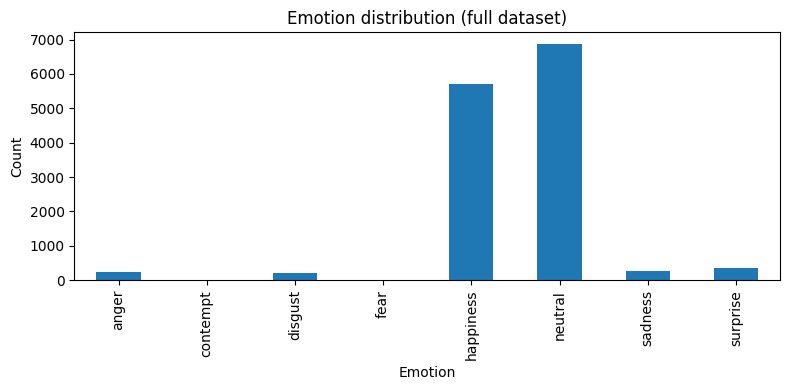

Train size: 10952
Val size: 1369
Test size: 1369
Loading train images...
Loading val images...
Loading test images...


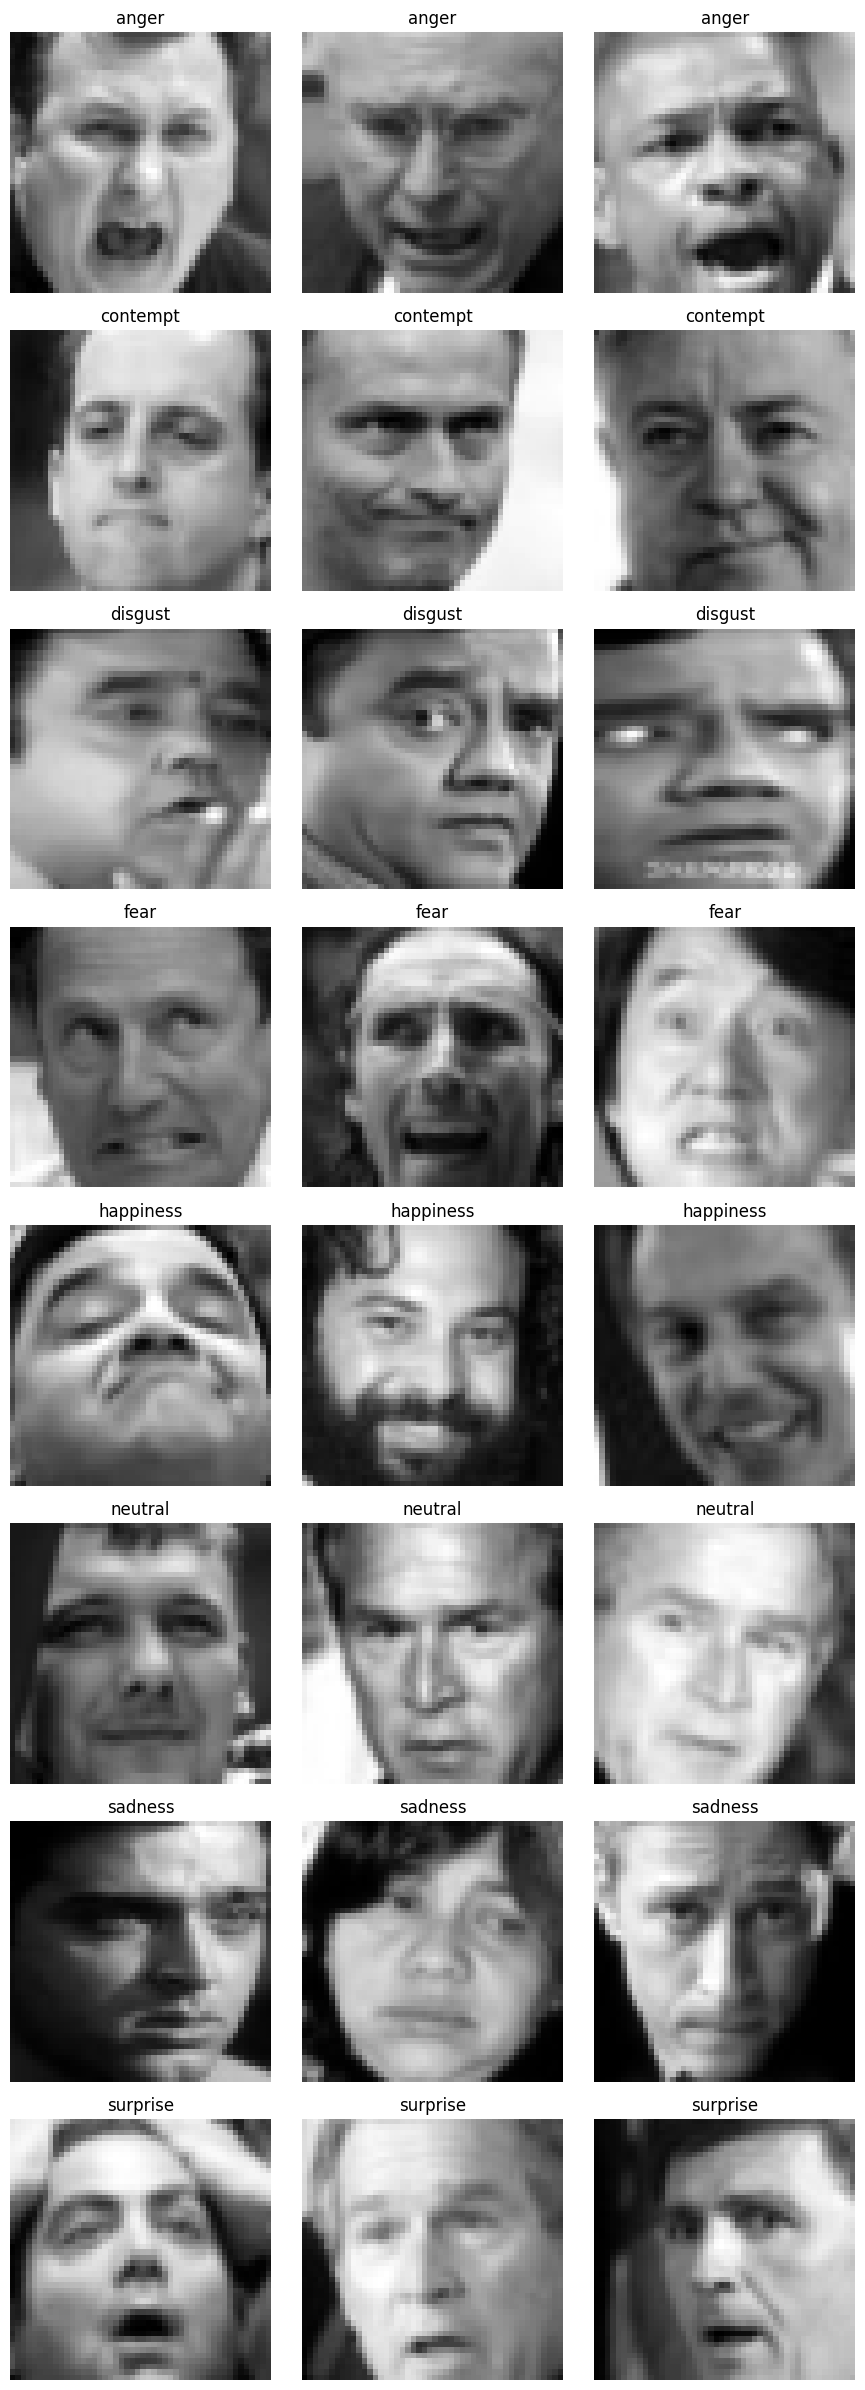


Preparing pixel features for Linear SVM...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Linear SVM params: {'clf__C': 0.1}
Best CV macro-F1 (Linear SVM): 0.2664526475684572

===== Linear SVM (pixels) =====
Test accuracy:  0.7290
Test macro-F1: 0.2810

Classification report:
              precision    recall  f1-score   support

       anger       0.27      0.12      0.17        25
    contempt       0.00      0.00      0.00         1
     disgust       0.30      0.29      0.29        21
        fear       0.00      0.00      0.00         2
   happiness       0.77      0.73      0.75       570
     neutral       0.74      0.82      0.78       687
     sadness       0.11      0.04      0.06        26
    surprise       0.27      0.16      0.20        37

    accuracy                           0.73      1369
   macro avg       0.31      0.27      0.28      1369
weighted avg       0.71      0.73      0.72      1369



/Users/bryannguyen/Emotion-Detection-Computer-Vision/Emotion-Detection-Computer-Vision/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/bryannguyen/Emotion-Detection-Computer-Vision/Emotion-Detection-Computer-Vision/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/bryannguyen/Emotion-Detection-Computer-Vision/Emotion-Detection-Computer-Vision/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precisi

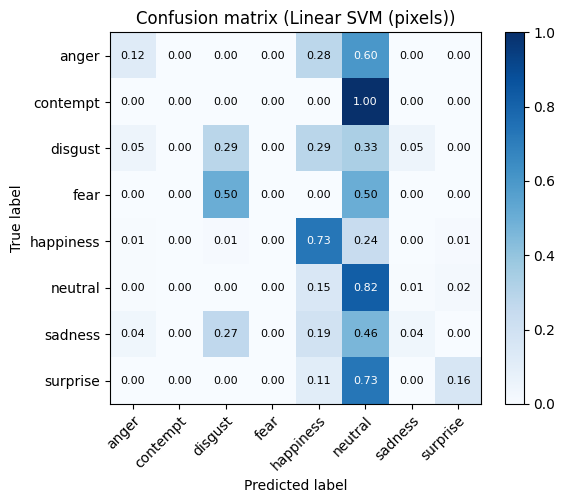


Extracting HOG features...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best RBF SVM params: {'clf__C': 1, 'clf__gamma': 0.001}
Best CV macro-F1 (RBF SVM): 0.35717307677092897

===== RBF SVM (HOG) =====
Test accuracy:  0.7852
Test macro-F1: 0.3770

Classification report:
              precision    recall  f1-score   support

       anger       0.32      0.32      0.32        25
    contempt       0.00      0.00      0.00         1
     disgust       0.36      0.67      0.47        21
        fear       0.00      0.00      0.00         2
   happiness       0.84      0.81      0.83       570
     neutral       0.84      0.83      0.84       687
     sadness       0.26      0.23      0.24        26
    surprise       0.27      0.41      0.32        37

    accuracy                           0.79      1369
   macro avg       0.36      0.41      0.38      1369
weighted avg       0.80      0.79      0.79      1369



/Users/bryannguyen/Emotion-Detection-Computer-Vision/Emotion-Detection-Computer-Vision/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/bryannguyen/Emotion-Detection-Computer-Vision/Emotion-Detection-Computer-Vision/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/bryannguyen/Emotion-Detection-Computer-Vision/Emotion-Detection-Computer-Vision/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precisi

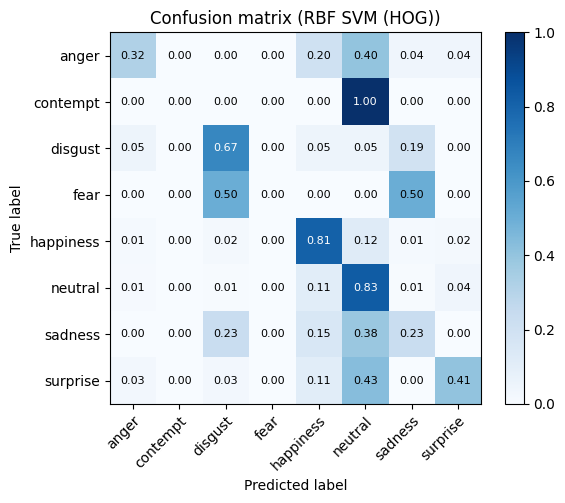

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score
)

DATA_DIR = "/Users/bryannguyen/Downloads/facial_expressions"
LEGEND_CSV = os.path.join(DATA_DIR, "data", "legend.csv")
IMAGE_DIR = os.path.join(DATA_DIR, "images")

IMG_SIZE = (48, 48)


# Data Loading Utilities
def load_metadata(legend_path=LEGEND_CSV):
    df = pd.read_csv(legend_path)
    if "image" not in df.columns:
        raise ValueError(f"'image' column not found. Columns are: {df.columns}")
    if "emotion" not in df.columns:
        raise ValueError(f"'emotion' column not found. Columns are: {df.columns}")

    df = df[["image", "emotion"]].copy()
    df["emotion"] = df["emotion"].astype(str).str.lower().str.strip()
    return df


def load_images(df, image_dir=IMAGE_DIR, img_size=IMG_SIZE, as_gray=True):
    X = []
    for fname in df["image"]:
        path = os.path.join(image_dir, fname)
        img = imread(path, as_gray=as_gray)
        img_resized = resize(img, img_size, anti_aliasing=True)
        X.append(img_resized)
    X = np.array(X, dtype=np.float32)
    return X


# EDA Plots
def plot_class_distribution(df, title="Emotion class distribution"):
    counts = df["emotion"].value_counts().sort_index()
    plt.figure(figsize=(8, 4))
    counts.plot(kind="bar")
    plt.title(title)
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


def show_example_images(X, y, class_names=None, n_per_class=3):
    unique_classes = sorted(np.unique(y))
    n_classes = len(unique_classes)
    fig, axes = plt.subplots(n_classes, n_per_class, figsize=(3 * n_per_class, 3 * n_classes))

    if n_classes == 1:
        axes = np.array([axes])

    for row, cls in enumerate(unique_classes):
        idxs = np.where(y == cls)[0]
        if len(idxs) == 0:
            continue
        chosen = np.random.choice(idxs, size=min(n_per_class, len(idxs)), replace=False)
        for col, idx in enumerate(chosen):
            ax = axes[row, col]
            ax.imshow(X[idx], cmap="gray")
            label = cls if class_names is None else class_names.get(cls, cls)
            ax.set_title(label)
            ax.axis("off")

        for col in range(len(chosen), n_per_class):
            axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


# Feature Extraction
def flatten_pixels(X):
    N = X.shape[0]
    return X.reshape(N, -1)


def extract_hog_features(X):
    features = []
    for img in X:
        feat = hog(
            img,
            orientations=8,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm="L2-Hys"
        )
        features.append(feat)
    return np.array(features, dtype=np.float32)


# Model Training Functions
def train_linear_svm(X_train, y_train):
    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", LinearSVC())
    ])

    param_grid = {
        "clf__C": [1e-3, 1e-2, 1e-1, 1, 10]
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(
        pipe,
        param_grid,
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)
    print("Best Linear SVM params:", grid.best_params_)
    print("Best CV macro-F1 (Linear SVM):", grid.best_score_)
    return grid.best_estimator_


def train_rbf_svm_hog(X_train, y_train):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", class_weight="balanced"))
    ])

    param_grid = {
        "clf__C": [0.1, 1, 10, 100],
        "clf__gamma": [1e-3, 1e-2, 1e-1, 1]
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(
        pipe,
        param_grid,
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)
    print("Best RBF SVM params:", grid.best_params_)
    print("Best CV macro-F1 (RBF SVM):", grid.best_score_)
    return grid.best_estimator_


# Evaluation utilities
def evaluate_model(name, model, X_test, y_test, normalize_cm=True):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")

    print(f"\n===== {name} =====")
    print(f"Test accuracy:  {acc:.4f}")
    print(f"Test macro-F1: {f1_macro:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    labels = sorted(np.unique(y_test))
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    if normalize_cm:
        cm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(labels)),
        yticks=np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        ylabel="True label",
        xlabel="Predicted label",
        title=f"Confusion matrix ({name})"
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, f"{cm[i, j]:.2f}",
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=8
            )

    fig.tight_layout()
    plt.show()

    return acc, f1_macro

# Main pipeline
def main():
    # Load metadata
    df = load_metadata(LEGEND_CSV)
    print(df.head())
    print("Total samples:", len(df))
    print("Class counts:\n", df["emotion"].value_counts())
    plot_class_distribution(df, title="Emotion distribution (full dataset)")

    # Train/Val/Test split (80/10/10)
    train_df, temp_df = train_test_split(
        df,
        test_size=0.2,
        stratify=df["emotion"],
        random_state=42
    )
    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.5,
        stratify=temp_df["emotion"],
        random_state=42
    )

    print("Train size:", len(train_df))
    print("Val size:", len(val_df))
    print("Test size:", len(test_df))

    # Load images
    print("Loading train images...")
    X_train_img = load_images(train_df)
    y_train = train_df["emotion"].values

    print("Loading val images...")
    X_val_img = load_images(val_df)
    y_val = val_df["emotion"].values

    print("Loading test images...")
    X_test_img = load_images(test_df)
    y_test = test_df["emotion"].values

    show_example_images(X_train_img, y_train, n_per_class=3)

    # Linear SVM on pixels
    print("\nPreparing pixel features for Linear SVM...")
    X_train_flat = flatten_pixels(X_train_img)
    X_val_flat = flatten_pixels(X_val_img)
    X_test_flat = flatten_pixels(X_test_img)

    # Combine train+val for final training after hyperparameter tuning
    X_lin_tune = np.vstack([X_train_flat, X_val_flat])
    y_lin_tune = np.concatenate([y_train, y_val])

    linear_svm = train_linear_svm(X_lin_tune, y_lin_tune)

    # Evaluate on test
    evaluate_model("Linear SVM (pixels)", linear_svm, X_test_flat, y_test)

    # RBF SVM on HOG features
    print("\nExtracting HOG features...")
    X_train_hog = extract_hog_features(X_train_img)
    X_val_hog = extract_hog_features(X_val_img)
    X_test_hog = extract_hog_features(X_test_img)

    X_hog_tune = np.vstack([X_train_hog, X_val_hog])
    y_hog_tune = np.concatenate([y_train, y_val])

    rbf_svm = train_rbf_svm_hog(X_hog_tune, y_hog_tune)

    # Evaluate on test
    evaluate_model("RBF SVM (HOG)", rbf_svm, X_test_hog, y_test)


if __name__ == "__main__":
    main()


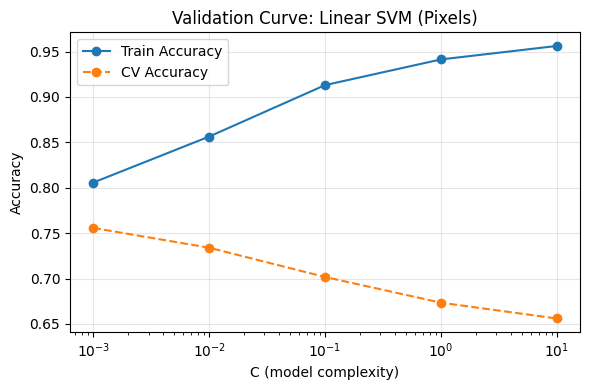

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, validation_curve

X_train_flat = flatten_pixels(X_train_img)

linear_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LinearSVC())
])

C_range = np.array([0.001, 0.01, 0.1, 1, 10])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

train_scores, val_scores = validation_curve(
    linear_pipe,
    X_train_flat,
    y_train,
    param_name="clf__C",
    param_range=C_range,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.semilogx(C_range, train_mean, marker="o", label="Train Accuracy")
plt.semilogx(C_range, val_mean, marker="o", linestyle="--", label="CV Accuracy")
plt.title("Validation Curve: Linear SVM (Pixels)")
plt.xlabel("C (model complexity)")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


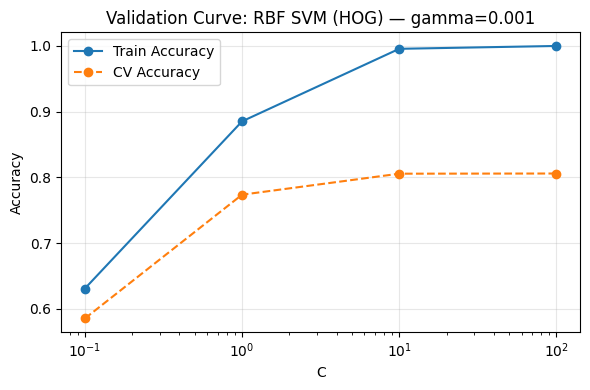

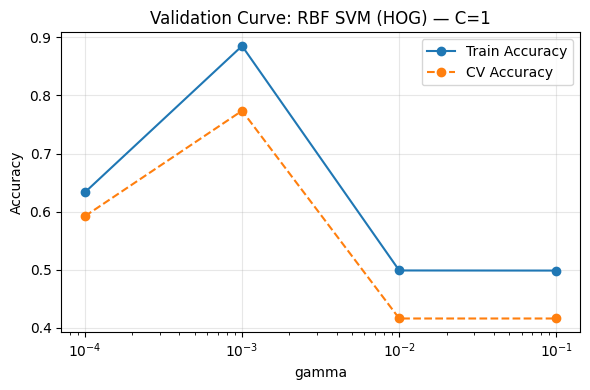

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, validation_curve

X_train_hog = extract_hog_features(X_train_img)

rbf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", class_weight="balanced"))
])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Vary C around best C=1, while holding gamma=0.001 fixed
C_range = np.array([0.1, 1, 10, 100])

rbf_pipe.set_params(clf__gamma=0.001)

train_scores_C, val_scores_C = validation_curve(
    rbf_pipe,
    X_train_hog,
    y_train,
    param_name="clf__C",
    param_range=C_range,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

plt.figure(figsize=(6,4))
plt.semilogx(C_range, train_scores_C.mean(axis=1), marker="o", label="Train Accuracy")
plt.semilogx(C_range, val_scores_C.mean(axis=1), marker="o", linestyle="--", label="CV Accuracy")
plt.title("Validation Curve: RBF SVM (HOG) — gamma=0.001")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Vary gamma around best gamma=0.001, while holding C=1 fixed
gamma_range = np.array([1e-4, 1e-3, 1e-2, 1e-1])

rbf_pipe.set_params(clf__C=1)

train_scores_g, val_scores_g = validation_curve(
    rbf_pipe,
    X_train_hog,
    y_train,
    param_name="clf__gamma",
    param_range=gamma_range,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

plt.figure(figsize=(6,4))
plt.semilogx(gamma_range, train_scores_g.mean(axis=1), marker="o", label="Train Accuracy")
plt.semilogx(gamma_range, val_scores_g.mean(axis=1), marker="o", linestyle="--", label="CV Accuracy")
plt.title("Validation Curve: RBF SVM (HOG) — C=1")
plt.xlabel("gamma")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
